# Predicting the Daily Bike-Sharing Rental Usage Using KNN Regression

## Introduction

details
- proposal
- why temperature?
- citation

## Methods & Results

In this analysis, we sought to understand and predict daily bike rental usage in Seoul based on temperature data, utilizing several R libraries for data manipulation, visualization, and modeling. 

#### Library loading:
We began by loading the necessary R libraries: 
tidyverse for data manipulation and visualization,tidymodels for modelling, janitor for data cleaning, and kknn for the k-nearest neighbors algorithm.

In [1]:
library(tidyverse)
library(tidymodels)
install.packages("janitor") # for clean_names
library(janitor)
install.packages("kknn")
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Data Acquisition and Data Wrangling 1:
- The data was sourced directly from a web URL using read_csv and immediately cleaned with clean_names to ensure consistent and valid column names
- The dataset was initially explored using the head function to understand the available data points and structure.

In [3]:
set.seed(1234)

# read data from web
bike_url <- "https://raw.githubusercontent.com/caiwwei/dsci-project-4/main/SeoulBikeData.csv"
bike_data <- read_csv(bike_url) |>
    clean_names() # tidy column names in dataset to contain no spaces

# showing a glance of raw data with clean names
head(bike_data)

Rows: 8760 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Date, Seasons, Holiday, Functioning Day
dbl (10): Rented Bike Count, Hour, Temperature_Celsius, Humidity, Wind speed...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


date,rented_bike_count,hour,temperature_celsius,humidity,wind_speed_m_per_s,visibility_10m,dew_point_temperature_celsius,solar_radiation,rainfall_mm,snowfall_cm,seasons,holiday,functioning_day
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes
01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes
01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes


#### Data wrangling 2:
We transformed the dataset from hourly to daily records by grouping the data by date and summarizing to get the average temperature (avg_temp) and total bike rentals (total_users) for each day, ensuring to include 
only the days where the bike rental system was operational.

In [4]:
set.seed(1234)

# convert data observations from hourly to daily by computing total daily users and average daily temperature
bike_condensed <- bike_data |>
    group_by(date) |> 
    filter(functioning_day == "Yes") |> # because we only care about days where the bike share service is operating
    summarize(avg_temp = mean(temperature_celsius),
              total_users = sum(rented_bike_count))

# showing a glance of the summarized datatable
head(bike_condensed)
tail(bike_condensed)

date,avg_temp,total_users
<chr>,<dbl>,<dbl>
01/01/2018,-1.283333,4290
01/02/2018,-3.866667,5377
01/03/2018,0.450000,5132
01/04/2018,15.183333,17388
01/05/2018,20.341667,26820
01/06/2018,23.708333,31928


date,avg_temp,total_users
<chr>,<dbl>,<dbl>
31/03/2018,13.941667,19247
31/05/2018,20.525000,31681
31/07/2018,32.525000,22897
31/08/2018,25.558333,27817
31/10/2018,7.529167,21545
31/12/2017,0.087500,3423


#### Exploratory Data Analysis (EDA)
- For the exploratory data analysis, we crafted a scatter plot to elucidate the relationship between two key variables: the average daily temperature and the total number of daily bike rental users. This visualization, depicted in Figure 1, is an integral component of our EDA, providing immediate visual insights into the nature of the data we are analyzing. The use of the alpha parameter was strategically chosen to adjust the point opacity in the graph, which enhances the visual distinction in areas where data points are densely plotted. This nuanced detail allows for better interpretation of data density and underlying patterns.
- Figure 1 reveals a discernible positive non-linear correlation between the average daily temperature and the bike rental count; as temperatures climb, so too does the usage of the bike-sharing system. This trend suggests that warmer days are more conducive to bike rentals, a logical inference given the outdoor nature of the activity. The strength and consistency of this trend were key observations that guided the subsequent predictive modelling phase, affirming our hypothesis that temperature is a significant predictor of bike rental demand. The scatter plot thus not only validated our data processing steps but also laid the foundation for building a predictive model grounded in a clear understanding of the variables at play.

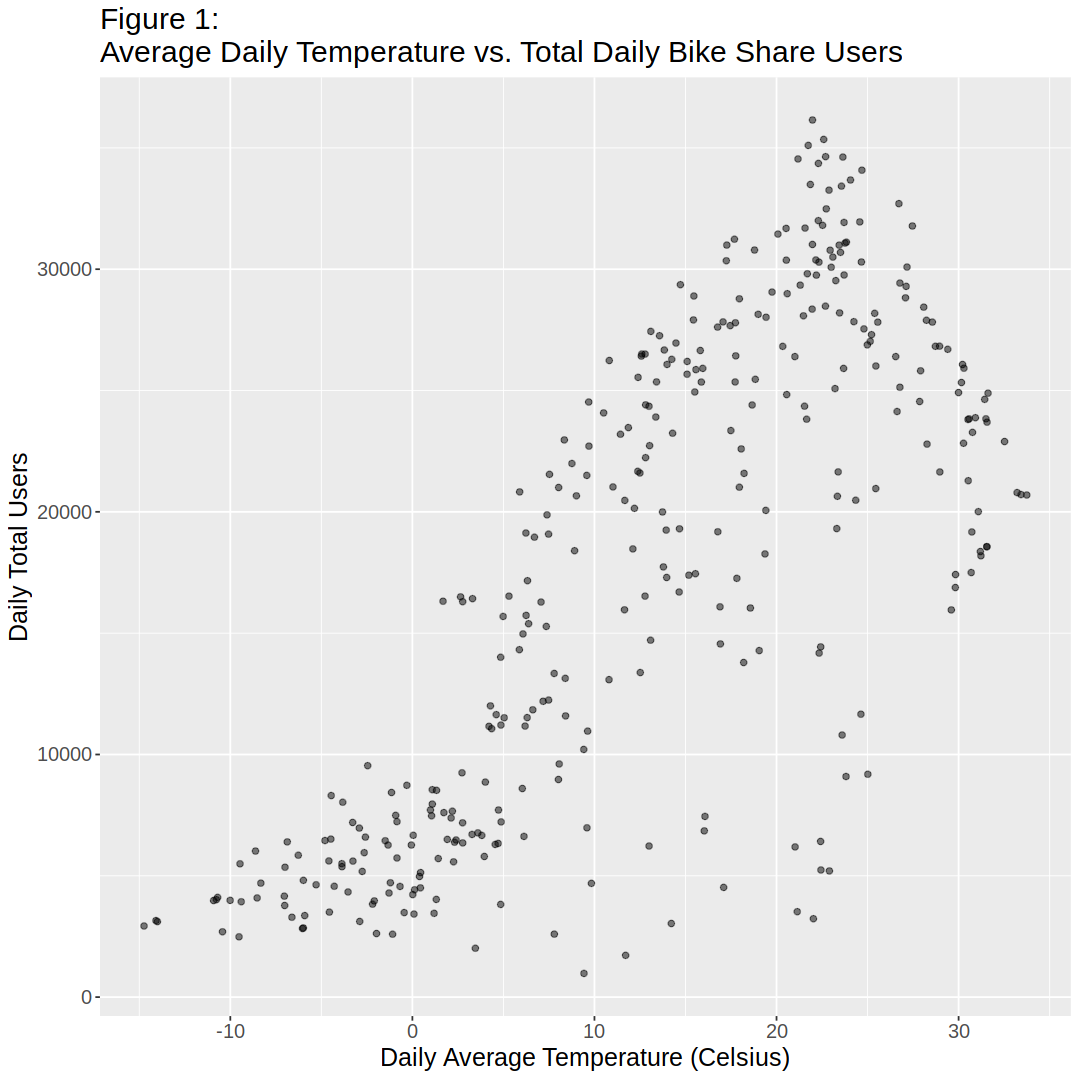

In [5]:
set.seed(1234)
# visualize the summarized data with a scatter plot, by placing the predictor variable (average daily temperature) on the x-axis and
# the response variable that we want to predict in this project (total daily users) on the y-axis, so as to depict relationship between
# average daily temperature (predictor variable) and total daily users (response variable)
options(repr.plot.width = 9, repr.plot.height = 9)

bike_plot <- ggplot(bike_condensed, aes(x = avg_temp, y = total_users)) +
    geom_point(alpha = 0.5) +
    xlab("Daily Average Temperature (Celsius)") +
    ylab("Daily Total Users") +
    ggtitle("Figure 1: \nAverage Daily Temperature vs. Total Daily Bike Share Users") +
    theme(text = element_text(size = 15))

bike_plot

#### Predictive Modelling 1:

For our analysis, we initiated the process by setting a seed with set.seed(1234), ensuring that any randomized operations could be replicated for consistency in future runs. We divided our dataset into a training set, comprising 75% of the data, and a testing set, making up the remaining 25%. This division was done with stratification on the total_users variable, meaning that the proportion of total daily users was consistent across both the training and testing sets to prevent sampling bias and to maintain the distribution's integrity.

Data preprocessing was a critical step; we normalized (scaled) and centred the avg_temp variable to ensure that the KNN model, sensitive to the scale of input data, could accurately interpret the variable's impact on bike rentals.

We opted for a KNN regression model for its ability to capture the complex, non-linear relationships observed in preliminary data analysis. To refine our model, we employed 5-fold cross-validation, a robust method that partitions the training set into five equal-sized subsamples. In each fold of cross-validation, four subsets were used for training the model, and the remaining one served as a validation set to evaluate model performance. This process was cycled through five times, with each subset getting a chance to validate the model, thus ensuring that every data point contributed to both training and validation. This method mitigates the model's vulnerability to peculiarities in the data split and helps in combating overfitting, as it ensures that the model's performance is tested on multiple independent subsets.
We tuned the KNN regression model by systematically testing a range of K values from 1 to 100. For each K, we calculated the Root Mean Squared Error (RMSE) on the validation folds. RMSE is a widely used measure of the differences between values predicted by a model and the values observed. The K value that resulted in the lowest average RMSE across all folds was selected as the optimal. In order to find the optimal K value, we plotted a line graph and visualized the effect of the number of neighbors on RMSE. Through this rigorous process, we determined that K=59 provided the best generalization performance for our model, balancing the bias-variance tradeoff effectively.

In [6]:
set.seed(1234)
# split the data into training and testing set; we choose to use a 75% training and 25% testing split
bike_split <- initial_split(bike_condensed, prop = 0.75, strata = total_users)
bike_training <- training(bike_split)
bike_testing <- testing(bike_split)

bike_split
bike_training
bike_testing

<Training/Testing/Total>
<264/89/353>

date,avg_temp,total_users
<chr>,<dbl>,<dbl>
01/02/2018,-3.86666667,5377
01/03/2018,0.45000000,5132
01/07/2018,22.02500000,3231
02/01/2018,-1.49166667,6446
02/02/2018,-2.64583333,5954
03/01/2018,-4.47916667,6512
03/02/2018,-6.61666667,3290
04/01/2018,-4.80000000,6453
05/02/2018,-9.40000000,3932


date,avg_temp,total_users
<chr>,<dbl>,<dbl>
01/01/2018,-1.28333333,4290
01/04/2018,15.18333333,17388
01/05/2018,20.34166667,26820
02/05/2018,16.07083333,7448
02/06/2018,23.51250000,30693
02/07/2018,22.43750000,5240
02/12/2017,1.32500000,8523
03/06/2018,23.71250000,29761
03/10/2018,17.24166667,30349


In [7]:
set.seed(1234)

# create recipe to preprocess the data by using the training dataset
bike_recipe <- recipe(total_users ~ avg_temp, data = bike_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

bike_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [8]:
set.seed(1234)

# create model specification for k-nn and tune the model as we are using cross-validation to determine
# the value of K (number of neighbors) we should use in this project according to the accuracy in order to improve our classifier
bike_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

bike_tune_spec

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [9]:
set.seed(1234)

bike_tune_workflow <- workflow() |>
    add_recipe(bike_recipe) |>
    add_model(bike_tune_spec)

# perform 5-fold cross-validation by evenly splitting training data into 5 folds
bike_vfold <- vfold_cv(bike_training, v = 5, strata = total_users)

# create a data frame containing the sequence of values of K that we want to try
k_vals <- tibble(neighbors = seq(from = 1, to = 100))

# obtaining the results (focusing on RMSE to determine the performance of our classifier) after fitting the model
bike_tune_results <- bike_tune_workflow |>
    tune_grid(resamples = bike_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

# showing the first and last few rows of the bike_tune_results
head(bike_tune_results)
tail(bike_tune_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,8134.445,5,572.8430,Preprocessor1_Model001
2,rmse,standard,7118.558,5,616.8990,Preprocessor1_Model002
3,rmse,standard,6782.921,5,525.6331,Preprocessor1_Model003
4,rmse,standard,6638.040,5,587.3665,Preprocessor1_Model004
5,rmse,standard,6527.143,5,533.4942,Preprocessor1_Model005
6,rmse,standard,6418.256,5,513.7224,Preprocessor1_Model006


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
95,rmse,standard,6276.001,5,355.3891,Preprocessor1_Model095
96,rmse,standard,6300.334,5,347.3441,Preprocessor1_Model096
97,rmse,standard,6316.355,5,346.7596,Preprocessor1_Model097
98,rmse,standard,6327.036,5,342.8939,Preprocessor1_Model098
99,rmse,standard,6332.642,5,342.1492,Preprocessor1_Model099
100,rmse,standard,6350.684,5,341.7234,Preprocessor1_Model100


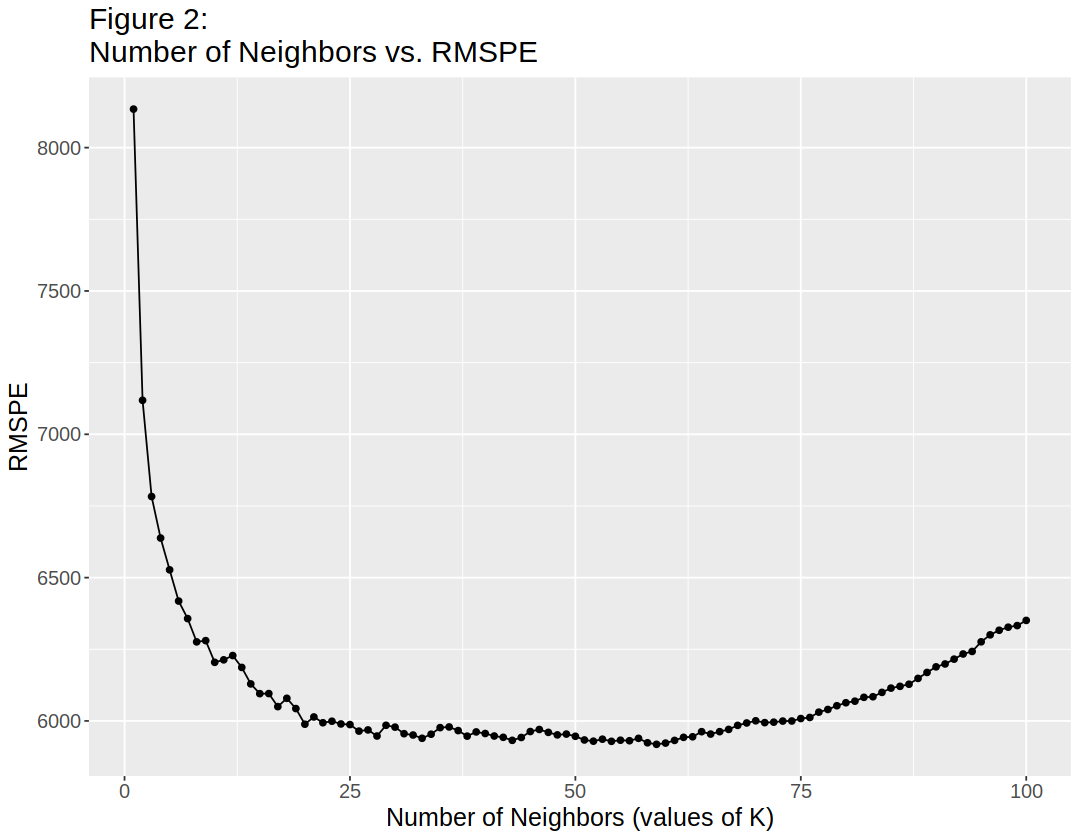

In [10]:
set.seed(1234)

# plotting the graph of Neighbors vs RMSPE that shows the relationship between RMSE and the number of neighbors used in the model
# so as to determine the value of K we should use in our final model by having a classifier with the lowest RMSE
options(repr.plot.width = 9, repr.plot.height = 7)

bike_tune_graph <- ggplot(bike_tune_results, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors (values of K)", y = "RMSPE") +
    ggtitle("Figure 2: \nNumber of Neighbors vs. RMSPE") +
    theme(text = element_text(size = 15))

bike_tune_graph

In [11]:
# just doublecheck the lowest RMSE 
# can delete afterwards
bike_tune_results |>
slice_min(mean)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
59,rmse,standard,5918.436,5,470.8355,Preprocessor1_Model059


In [12]:
set.seed(1234)

# select K val with the smallest RMSPE
k_min <- bike_tune_results |> 
    filter(mean == min(mean)) |>
    select(neighbors) |>
    pull()

k_min

[1] 59

In [13]:
set.seed(1234)

# create model specification for k-nn regression using the K values determined
bike_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("regression")

bike_fit <- workflow() |>
    add_recipe(bike_recipe) |>
    add_model(bike_spec) |>
    fit(data = bike_training)

bike_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(59L,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 4331.59
Minimal mean squared error: 35754494
Best kernel: rectangular
Best k: 59

#### Model Evaluation:

The trained model was used to make predictions on the testing set, and the results were summarized to calculate the RMSE, which provided a quantitative measure of the model's accuracy.

In [14]:
set.seed(1234)

bike_preds <- bike_fit |>
    predict(bike_testing) |>
    bind_cols(bike_testing)

bike_preds

.pred,date,avg_temp,total_users
<dbl>,<chr>,<dbl>,<dbl>
6761.627,01/01/2018,-1.28333333,4290
21975.136,01/04/2018,15.18333333,17388
25119.000,01/05/2018,20.34166667,26820
22093.627,02/05/2018,16.07083333,7448
25724.085,02/06/2018,23.51250000,30693
25437.797,02/07/2018,22.43750000,5240
7859.169,02/12/2017,1.32500000,8523
25597.102,03/06/2018,23.71250000,29761
22698.085,03/10/2018,17.24166667,30349


In [15]:
set.seed(1234)

bike_summary <- bike_preds |>
    metrics(truth = total_users, estimate = .pred) |>
    filter(.metric == "rmse")

bike_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6033.689


#### Visualization:

A final visualization was created, overlaying the model's predictions onto the original data using a scatter plot for the actual values and a red line for the predicted values. This allowed us to assess the fit of the model visually.

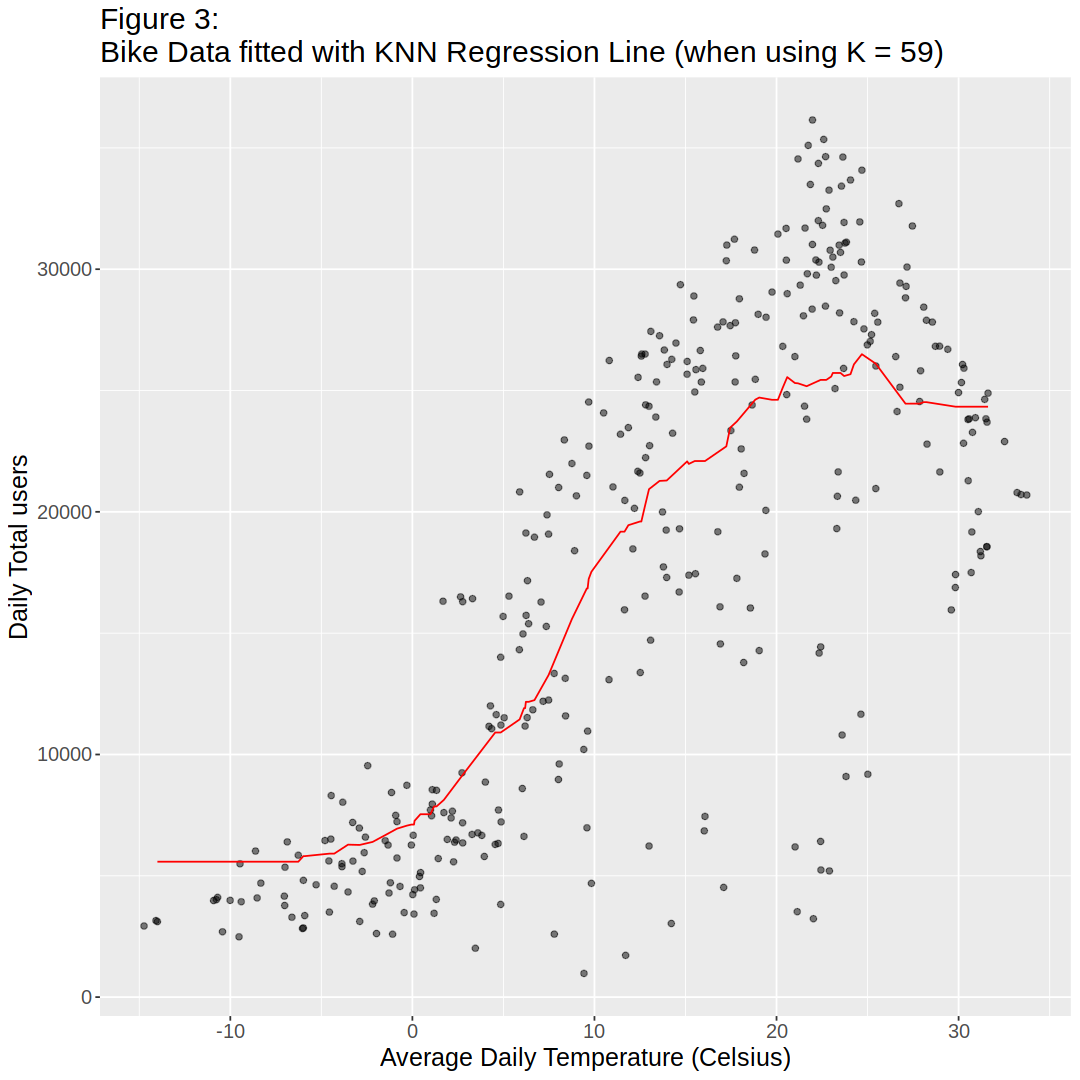

In [16]:
set.seed(1234)

options(repr.plot.width = 9, repr.plot.height = 9)

bike_analysis_plot <- ggplot(bike_condensed, aes(x = avg_temp, y = total_users)) +
    geom_point(alpha = 0.5) + 
    geom_line(data = bike_preds,
              mapping = aes(x = avg_temp, y = .pred),
              color = "red") + 
    labs(x = "Average Daily Temperature (Celsius)", y = "Daily Total users") + 
    ggtitle("Figure 3: \nBike Data fitted with KNN Regression Line (when using K = 59)") +
    theme(text = element_text(size = 15))

bike_analysis_plot

#### Interpretation of Results:

The resulting plot, "Figure 3," demonstrated the KNN model's effectiveness, showing how the number of daily users tends to increase with higher temperatures. The plot was carefully labelled with axes titles and a legend, ensuring clarity and effective communication of the findings.

Throughout the analysis, we emphasized reproducibility and methodological precision, ensuring that each step could be consistently replicated. The final graph encapsulated the results of the model, highlighting the temperature's predictive power for bike rental usage and validating the use of KNN regression in this context.

## Discussion

discussion...

## Reference

at least 2 citations

FIRST DRAFT